In [1]:
import numpy as np
from QAM_EncoderDecoder import * 
from scipy.io.wavfile import write, read
import matplotlib.pyplot as plt
import sounddevice as sd
import soundfile as sf
from IPython.display import Audio
from scipy import interpolate, signal

%matplotlib inline

In [2]:
# constants

N = 2048
prefix_no = 256
fs = 44100

In [3]:
def random_symbol_generator(length, seed=2021):

    rng = np.random.default_rng(seed)
    random_sequence = rng.integers(low=0, high=4, size=length)

    mapping = {
        0:  1+1j,
        1: -1+1j,
        2: -1-1j,
        3:  1-1j
    }

    random_symbols = [mapping[r] for r in random_sequence]
    
    return random_symbols


In [894]:
def define_chirp(sec):
    """returns standard log chirp waveform and its time-reverse"""
    
    k = 1000 # necessary?
    w1 = 100
    w2 = 6000 # standardise range
    
    t = np.linspace(0, sec, int(fs*sec))
    
    ch = signal.chirp(t, f0=w1, f1=w2, t1=sec, method='logarithmic') / 5
    #ch *= (1-np.exp(-k*t))*(1-np.exp(-k*(sec-t)))
    
    inv_ch = np.flip(ch) # have the inverse as a single chirp or the repeated chirps??
    
    return ch, inv_ch

In [895]:
def known_OFDM_frames(repeats=10):
    
    known_rand_symbols = random_symbol_generator(N//2-1, 1966) # dc offset if not chosen right?
    known_frame = np.zeros(N//2, dtype=complex)
    known_frame[1:] = known_rand_symbols
    known_frame = np.append(known_frame, np.append(0,np.conj(known_frame)[:0:-1]))
    known_frame = np.fft.ifft(known_frame)
    known_frame = np.real(known_frame)
    known_frame = np.append(known_frame[N-prefix_no:N], known_frame)
    
    known_frames = np.tile(known_frame, repeats)
    
    return known_frames


In [896]:
def ideal_channel_response(signal):
    """Returns channel output for tx signal"""
    
    channel = np.genfromtxt('channel.csv',delimiter=',')
    channel_op = np.convolve(signal, channel)
    
    return channel_op

def real_channel_response(signal):
    """Records and returns rx signal after writing to file"""
    
    wait_time = np.ceil(len(signal)/fs) + 1
    print("Recording for ", wait_time, " seconds")
    

    recording = sd.rec(int(wait_time * fs), samplerate=fs, channels=1)
    sd.wait()

    sf.write('sound_files/sync_long_rec.wav', recording, fs)

    print("Finished")
    recording = recording[:, 0]
    
    return recording  

In [897]:
def matched_filter(signal, match):
    """Returns convolution of signal with matched filter and its peak index"""
    
    convolution = np.convolve(signal, match)
    peak_index1 = np.argmax(np.abs(convolution[:len(convolution)//2])) # check 1st half of signal
    peak_index2 = np.argmax(np.abs(convolution[len(convolution)//2:])) + len(convolution)//2 # check 2nd half of signal
    
    return convolution, peak_index1, peak_index2

In [898]:
def data_to_OFDM(filename):
    
    bits_tran = file_to_bitstr(filename)
    symbols_tran = encode_bitstr2symbols(bits_tran)
    data_tran = symbol_to_OFDMframes(symbols_tran,N,prefix_no,max_bin=N//4)
    data_tran = np.real(data_tran)
    
    return data_tran


def data_add_pilots(filename, min_bin, max_bin):
    
    seed = 2021 # standardised across teams

    rng = np.random.default_rng(seed)
    length_random_sequence = N//2 # need 511 extra symbols
    random_sequence = rng.integers(low=0, high=4, size=length_random_sequence)

    mapping = {
        0:  1+1j,
        1: -1+1j,
        2: -1-1j,
        3:  1-1j}

    frequency_filler = [mapping[r] for r in random_sequence]
    
    K = max_bin # so 512 info bins, might reduce in future
    P = K // 16
    pilotValue = 1 + 1j # need to change over
    
    allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])
    pilotCarriers = allCarriers[1::K//P] # Pilots are every (K//P)th carrier.
    dataCarriers = np.delete(allCarriers, pilotCarriers)
    dataCarriers = np.delete(dataCarriers, [0])
    
    data_bits = file_to_bitstr(filename)
    data_symbols= encode_bitstr2symbols(data_bits)

    carriers_required = int(np.ceil(len(data_symbols)/len(dataCarriers)))
    excess = int(len(dataCarriers) * carriers_required) - len(data_symbols)
    data_symbols = np.append(data_symbols, frequency_filler[:excess])
    print(carriers_required, excess, len(data_symbols), len(dataCarriers))

    OFDM_frames = []
    for i in range(0, carriers_required*len(dataCarriers), len(dataCarriers)):
        
        OFDM_symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
        OFDM_symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers
        OFDM_symbol[dataCarriers] = data_symbols[i:i+len(dataCarriers)]  # allocate the data subcarriers  
        OFDM_symbol = np.append(OFDM_symbol, frequency_filler[:N//2-K]) # 
        OFDM_symbol = np.append(OFDM_symbol, np.append(0,np.conj(OFDM_symbol)[:0:-1]))
        OFDM_symbol = np.fft.ifft(OFDM_symbol)
        OFDM_symbol = np.append(OFDM_symbol[N-prefix_no:N], OFDM_symbol)   
        #print(OFDM_symbol)
        OFDM_symbol = np.real(OFDM_symbol)
        OFDM_frames.append(OFDM_symbol)   
        
    return OFDM_frames, [allCarriers, pilotCarriers, dataCarriers]  

def data_remove_pilots(all_frames, carrier_indices, channel_fft, filename, max_bin, underfill=0):
    
    pilot_indices = carrier_indices[1]
    data_indices = carrier_indices[2]
    
    pilot_symbols = []
    data_symbols = []
    bits = ""
    for i in range(len(all_frames)):
        
        frame_no_cp = all_frames[i][prefix_no:]
        frame_dft = np.fft.fft(frame_no_cp)

        pilots = frame_dft[pilot_indices]
        data = frame_dft[data_indices]
        
        bits+=decode_symbols_2_bitstring(data, channel_fft[data_indices])
        
        pilot_symbols.append(pilots)
        data_symbols.append(data)
    
    bitstr_to_file(bits, filename)
    
    return data_symbols, pilot_symbols
    
def data_remove_pilots_correct_phase(all_frames, carrier_indices, channel_fft, filename, max_bin, underfill=0):
    
    pilot_indices = carrier_indices[1]
    data_indices = carrier_indices[2]
    
    pilot_symbols = []
    data_symbols = []
    bits = ""
    for i in range(len(all_frames)):
        
        frame_no_cp = all_frames[i][prefix_no:]
        frame_dft = np.fft.fft(frame_no_cp)

        pilots = frame_dft[pilot_indices]
        data = frame_dft[data_indices]
        
        pilots_phase = np.unwrap(np.angle(pilots / channel_fft[carrier_indices[1]])) # very basic linear correction of phase
        phase_adjustment = np.polyfit(carrier_indices[1], pilots_phase, 1)[0]
        
        pilots *=  np.exp(-1j*phase_adjustment*carrier_indices[1])
        data *=  np.exp(-1j*phase_adjustment*carrier_indices[2])
        
        bits+=decode_symbols_2_bitstring(data, channel_fft[data_indices])
        
        pilot_symbols.append(pilots)
        data_symbols.append(data)
    
    bitstr_to_file(bits, filename)
    
    return data_symbols, pilot_symbols   


def data_add_random_pilots(filename, min_bin, max_bin):

    frequency_filler = random_symbol_generator(N//2)
    
    all_carriers = np.arange(min_bin, max_bin) # min_bin, ..., max_bin-1
    pilot_ratio = 16
    pilot_carriers = all_carriers[0:-1:pilot_ratio]
    data_carriers = np.delete(all_carriers, pilot_carriers-min_bin)
    
    data_bits = file_to_bitstr(filename)
    data_symbols= encode_bitstr2symbols(data_bits)
    carriers_required = int(np.ceil(len(data_symbols)/len(data_carriers)))
    
    OFDM_frames = []
    for i in range(0, carriers_required):

        frame = np.zeros(N//2, dtype=complex)
        frame[1:N//2-1] = frequency_filler[1:N//2-1]
        data_to_add = data_symbols[i*len(data_carriers):(i+1)*len(data_carriers)]
        frame[data_carriers[:len(data_to_add)]] = data_to_add

        frame = np.append(frame, np.append(0, np.conj(frame)[:0:-1]))
        OFDM_frame = np.real(np.fft.ifft(frame, N))
        OFDM_frame = np.append(OFDM_frame[N-prefix_no:N], OFDM_frame)

        OFDM_frames.append(OFDM_frame)

    underfill = len(data_to_add) # for last frame only

    pilot_values = [frequency_filler[x] for x in pilot_carriers]
    
    return OFDM_frames, underfill, [all_carriers, pilot_carriers, data_carriers], pilot_values


def data_remove_random_pilots_correct_phase(all_frames, carrier_indices, channel_fft, filename, pilot_values, underfill=0):
    
    pilot_indices = carrier_indices[1]
    data_indices = carrier_indices[2]
    
    pilot_symbols = []
    data_symbols = []
    
    bits = ""
    for i in range(len(all_frames)):
        
        frame_no_cp = all_frames[i][prefix_no:]
        frame_dft = np.fft.fft(frame_no_cp)

        pilots = frame_dft[pilot_indices]
        data = frame_dft[data_indices]
        
        pilots_demod = pilots / channel_fft[pilot_indices]
        pilots_phase_change = np.angle(pilots_demod / pilot_values) # divide by each known pilot symbol and get phase change
        
        phase_adjustment = np.polyfit(pilot_indices, np.unwrap(pilots_phase_change), 1)[0] # take gradient, intercept should be zero
        
        pilots *=  np.exp(-1j*phase_adjustment*carrier_indices[1])
        data *=  np.exp(-1j*phase_adjustment*carrier_indices[2])
        
        if (i==len(all_frames)-1) and (underfill != 0):
            print("Last frame")
            bits+=decode_symbols_2_bitstring(data[:underfill], channel_fft[data_indices][:underfill])
        else:
            bits+=decode_symbols_2_bitstring(data, channel_fft[data_indices])
        
        pilot_symbols.append(pilots)
        data_symbols.append(data)
        
    bitstr_to_file(bits, filename)
    
    return data_symbols, pilot_symbols



In [899]:
def process_transmission(signal, start, length, offset=0):
    
    start += offset
    trimmed_frames = signal[start:start+length]
    split_frames = np.split(trimmed_frames, length/(N+prefix_no))
    
    average_frame = np.zeros(N+prefix_no)
    for frame in split_frames:     
        average_frame = np.add(average_frame, frame)
    average_frame /= (length/(N+prefix_no))
    
    return split_frames, average_frame

In [900]:
def estimate_channel_response(frame, known_frame):
    """Returns time and frequency channel impulse response from known OFDM symbols"""
    
    known_frame = known_frame[prefix_no:]
    frame = frame[prefix_no:] 

    known_symbol = np.fft.fft(known_frame, N)
    OFDM_symbol = np.fft.fft(frame, N)

    channel_freq_response = np.zeros(N//2, dtype=complex)
    np.divide(OFDM_symbol[:N//2], known_symbol[:N//2], out=channel_freq_response, where=known_symbol[:N//2] != 0) # should catch divide by zero errors
    
    channel_freq_response = np.append(channel_freq_response, np.append(0,np.conj(channel_freq_response)[:0:-1]))
    
    channel_imp_response = np.fft.ifft(channel_freq_response, N)
    channel_imp_response = np.real(channel_imp_response)
    
    return channel_freq_response, channel_imp_response

about to do encode_bitstr2symbols encoding
encode_bitstr2symbols encoding finished


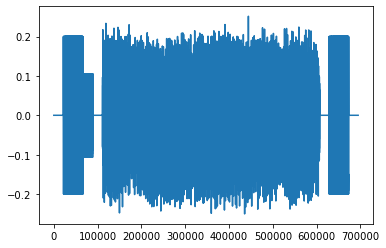

In [911]:
ch_len = 1
ch, inv_ch = define_chirp(ch_len)

known_frames = known_OFDM_frames(10) # scaling

data_frames, underfill_bin, carrier_indices, pilot_vals = data_add_random_pilots('texttst.txt', 20, 575) # c. 400-12000Hz range
data_frames = np.ravel(data_frames) # parallel to serial

gap = int(0.5*fs) # 1 sec

tx_signal = np.concatenate((np.zeros(gap), ch, known_frames, np.zeros(gap), data_frames, np.zeros(gap), ch, np.zeros(gap)), axis=None) # decide on padding

plt.plot(tx_signal)

filename = 'sound_files/transmit.wav'
sf.write(filename, tx_signal, fs)

In [902]:
#sd.play(tx_signal, fs)
#sd.wait()

In [940]:
# choose to test ideal or real channel

rx_signal = ideal_channel_response(tx_signal)    
#rx_signal = real_channel_response(tx_signal)

# can add in own method of recording files, just assign to rx_signal

#from pydub import AudioSegment
#recording = AudioSegment.from_file("sound_files/Record6.wav", format="wav")
#recording = recording.get_array_of_samples()
#plt.plot(recording[:])
#rx_signal = np.array(recording)

In [941]:
conv, peak_start, peak_end = matched_filter(rx_signal, inv_ch)

Peak start:  66150
Peak end:  672750
Actual sampling frequency:  44100.0


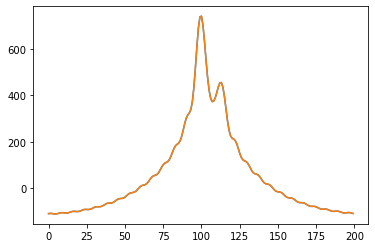

In [942]:
plt.plot(conv[peak_start-100:peak_start+100])
plt.plot(conv[peak_end-100:peak_end+100])
print("Peak start: ", peak_start)
print("Peak end: ", peak_end)

expected_ch_gap = len(known_frames) + len(data_frames) + len(ch) + 2*gap
actual_ch_gap = peak_end - peak_start

sampling_ratio = actual_ch_gap / expected_ch_gap

print("Actual sampling frequency: ", 44100*sampling_ratio)
#print("Extra sample after every", int((1/(sampling_ratio-1))), "samples")

694829


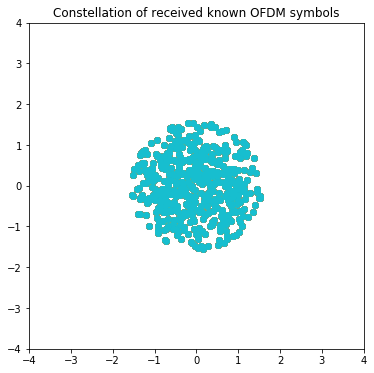

In [990]:
diff = -100  # variable

print(len(rx_signal))

known_start = peak_start

all_frames, avg_frame = process_transmission(rx_signal, known_start, len(known_frames), diff)

plt.figure(figsize=(6, 6))
for i in range(len(all_frames)):
    tst_symbols = np.fft.fft(all_frames[i][prefix_no:], N)[1:N//4]
    plt.scatter(np.real(tst_symbols), np.imag(tst_symbols), label=i)
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.title('Constellation of received known OFDM symbols')

In [991]:
freq_response, imp_response = estimate_channel_response(avg_frame, known_frames[:N+prefix_no]) # want just the single (repeated) ofdm frame

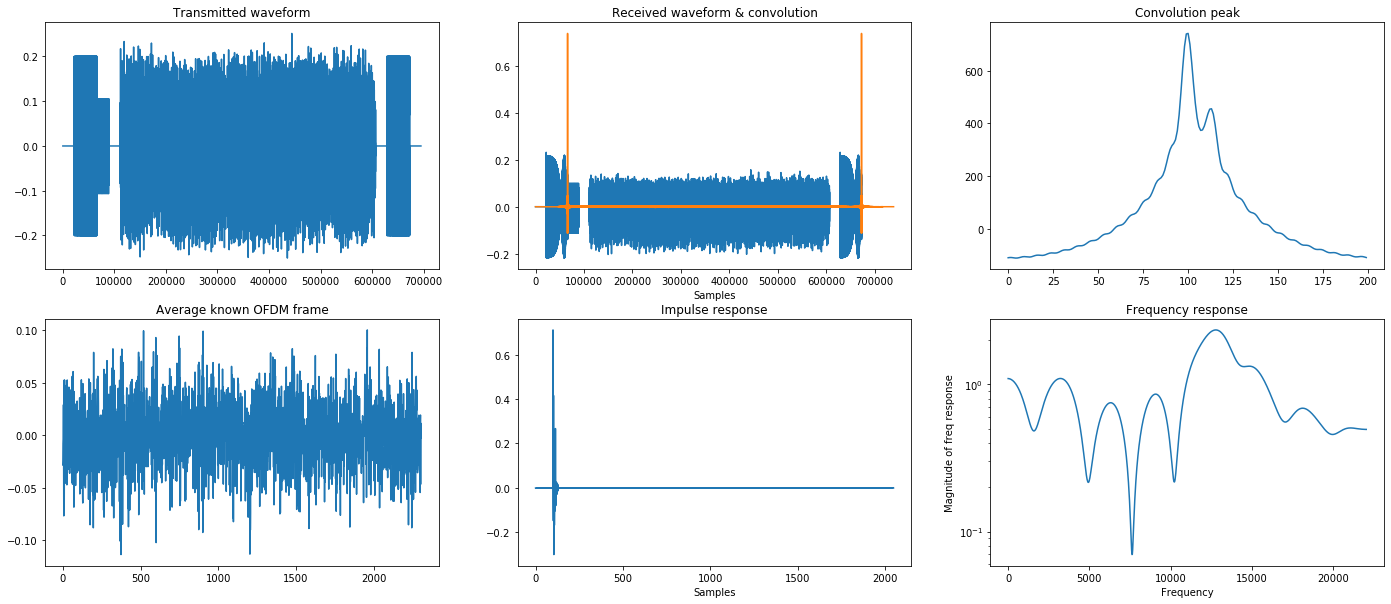

In [992]:
figs, axs = plt.subplots(2, 3, figsize=(24,10))
axs[0][0].plot(tx_signal)
axs[0][0].set_title('Transmitted waveform')
axs[0][1].plot(rx_signal)
axs[0][1].set_title('Received waveform & convolution')
axs[0][1].plot(conv/1000)
axs[0][1].set_xlabel('Samples')
axs[0][2].set_title('Convolution peak')
axs[0][2].plot(conv[peak_start-100:peak_start+100])

axs[1][0].set_title('Average known OFDM frame')
axs[1][0].plot(avg_frame)
axs[1][1].set_title('Impulse response')
axs[1][1].set_xlabel('Samples')
axs[1][1].plot(imp_response[:])
axs[1][2].set_title('Frequency response')
axs[1][2].set_ylabel('Magnitude of freq response')
axs[1][2].set_xlabel('Frequency')
axs[1][2].semilogy(np.linspace(1, fs//2 -1, N//2-2), np.abs(freq_response[1:N//2-1]))



111240
495360


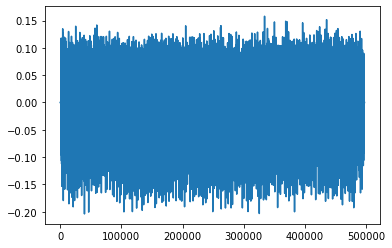

In [993]:
data_begin = peak_start + len(known_frames) + gap # include gap
print(data_begin)
print(len(data_frames))

rx_data_full = rx_signal[data_begin:data_begin+len(data_frames)]
rx_data_frames = np.split(rx_data_full, len(rx_data_full)/(N+prefix_no))

# carrier indices = [allCarriers, pilotCarriers, dataCarriers]

plt.plot(rx_signal[data_begin-1000:data_begin+len(data_frames)+1000])


In [994]:
rx_just_data, rx_just_pilots = data_remove_pilots(rx_data_frames, carrier_indices, freq_response, 'decoded_texttst.txt', max_bin=N//4)
# these are data & pilot values before being divided by the channel fft

print(np.shape(rx_just_pilots))

bitstr written to  decoded_texttst.txt
(215, 35)


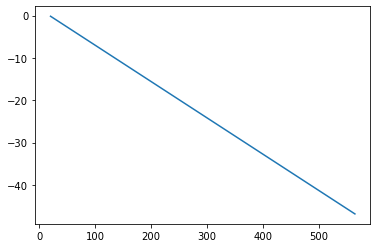

In [995]:
# use to get integer num samples off by looking at gradient of first symbol for a range of synchronisation

rx_just_pilots = np.divide(rx_just_pilots, pilot_vals)

pilots_phase = np.unwrap(np.angle(rx_just_pilots / freq_response[carrier_indices[1]]))
phase_fit = []
for p_phase in pilots_phase:
    lin_fit = np.polyfit(carrier_indices[1], p_phase, 1)
    phase_fit.append(lin_fit)
    
plt.plot(carrier_indices[1], np.unwrap(np.angle(rx_just_pilots / freq_response[carrier_indices[1]])[0])  )

[-0.08590292  1.57079633]


Text(0.5, 1.0, 'Phase change of pilot symbols through the OFDM frame')

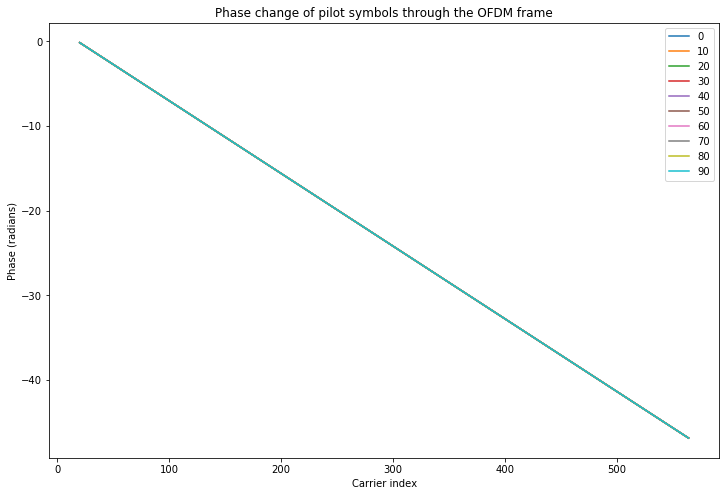

In [996]:
plt.figure(figsize=(12, 8))
for i in range(0, 100, 10):
    plt.plot(carrier_indices[1][:], pilots_phase[i][:], label=i) # - phase_fit[i][0]*carrier_indices[1] - phase_fit[i][1], label=i)
    #plt.plot(carrier_indices[1], phase_fit[i][0]*carrier_indices[1] + phase_fit[i][1], label=i)
    
print(phase_fit[0])
#plt.ylim(-200, 200)
plt.legend()
plt.xlabel('Carrier index')
plt.ylabel('Phase (radians)')
plt.title('Phase change of pilot symbols through the OFDM frame')

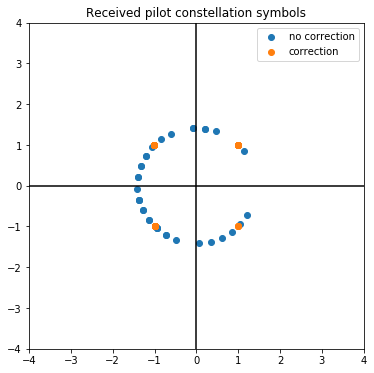

In [997]:
plt.figure(figsize=(6, 6))


for i in range(1):

    equalised_symbols = rx_just_pilots[i] * pilot_vals / freq_response[carrier_indices[1]]
    e = 0
    plt.scatter(np.real(equalised_symbols), np.imag(equalised_symbols), label='no correction')
    e = phase_fit[i][0] # get value from best fit of phase
    equalised_symbols *=  np.exp(-1j*e*carrier_indices[1])
    #print(np.exp(-1j*e*carrier_indices[1]))
    plt.scatter(np.real(equalised_symbols), np.imag(equalised_symbols), label='correction')
        
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.vlines(0, -4, 4)
plt.hlines(0, -4, 4)
plt.title('Received pilot constellation symbols')
plt.legend()

Text(0.5, 1.0, 'Received data constellation symbols')

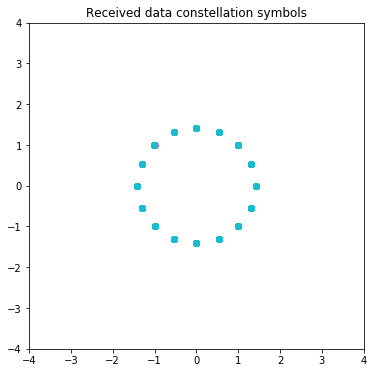

In [998]:
plt.figure(figsize=(6, 6))

for i in range(10):

    equalised_symbols = rx_just_data[i] / freq_response[carrier_indices[2]]
    e = phase_fit[i][0] # get value from best fit of phase
    equalised_symbols *=  np.exp(-1j*e*carrier_indices[2])
    plt.scatter(np.real(equalised_symbols), np.imag(equalised_symbols), label=i)
        
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.title('Received data constellation symbols')
#plt.legend()

In [999]:
#rx_just_data_corrected, rx_just_pilots_corrected = data_remove_pilots_correct_phase(rx_data_frames, carrier_indices, freq_response, 'decoded_texttst.txt', max_bin=N//4)
rx_just_data_corrected, rx_just_pilots_corrected = data_remove_random_pilots_correct_phase(rx_data_frames, carrier_indices, freq_response, 'decoded_texttst.txt', pilot_vals, underfill_bin)

Last frame
bitstr written to  decoded_texttst.txt


In [1000]:
#import matplotlib.image as mpimg
#img = mpimg.imread('decoded_test_image.png', 'wb')
#print(img)
#imgplot = plt.imshow(img)


In [1001]:
#plt.imshow(rx_just_data_corrected, interpolation='nearest')
#plt.show()